# Mean-Reversion Strategy Backtest for Gold and Silver Plan

## Major Assumptions
This analysis assumes gold and silver prices exhibit a cointegrating relationship suitable for pairs trading. We use daily price data over a multi-year period with the Engle-Granger two-step method to test for cointegration. Entry/exit signals are based on z-score thresholds of ±2σ with mean-crossing exits. Transaction costs of 0.1% per trade are incorporated to ensure realistic performance metrics. The hedge ratio from linear regression determines position sizing between GLD and SLV.

## Plan
- [x] Establish cointegration relationship between gold and silver
  - [x] Obtain historical daily price data for GLD and SLV ETFs and perform Engle-Granger cointegration test
  - [x] Calculate spread series, verify stationarity using ADF test, and visualize spread behavior with z-scores
- [x] Design and implement mean-reversion trading strategy
  - [x] Define entry/exit rules based on z-score thresholds with position sizing based on hedge ratio
  - [x] Generate trading signals and calculate daily P&L incorporating transaction costs
- [x] Backtest strategy and evaluate performance
  - [x] Calculate comprehensive performance metrics including Sharpe ratio, maximum drawdown, win rate, and profit factor
  - [x] Visualize equity curve evolution, drawdown periods, and trade distribution to assess strategy behavior over time
- [x] Analyze results and identify optimization opportunities
  - [x] Document strategy strengths, weaknesses, and key performance drivers from backtest results
  - [x] Provide recommendations for parameter optimization and risk management improvements

# Mean-Reversion Strategy Backtest: Gold vs Silver

## Welcome! 👋

This notebook implements a **pairs trading mean-reversion strategy** between gold and silver using daily closing prices from the last 3 years.

### Analysis Overview

We will:
1. **Download historical price data** for gold (GLD ETF) and silver (SLV ETF) 
2. **Test for cointegration** using the Engle-Granger two-step method
3. **Build a trading strategy** based on z-score deviations of the spread
4. **Backtest the strategy** with realistic transaction costs
5. **Evaluate performance** using key metrics (Sharpe ratio, returns, drawdown)

### Key Concepts

- **Cointegration**: Two non-stationary time series that maintain a stable long-term relationship
- **Mean Reversion**: The tendency for the spread between cointegrated assets to return to its mean
- **Engle-Granger Test**: Statistical test to determine if two time series are cointegrated
- **Z-Score Trading**: Enter positions when spread deviates significantly from mean, exit when it reverts

Let's begin! 🚀

In [6]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller, coint

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [3]:
# Use the existing GLD and SLV data from kernel
# The kernel already has gld and slv DataFrames loaded

# Extract closing prices from the multi-level column structure
prices = pd.DataFrame({
    'GLD': gld[('Close', 'GLD')],
    'SLV': slv[('Close', 'SLV')]
}).dropna()

print(f"✓ Using existing price data from kernel")
print(f"  - Date range: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"  - Total trading days: {len(prices)}")
print(f"\nFirst few rows:")
print(prices.head())
print(f"\nLast few rows:")
print(prices.tail())
print(f"\nBasic statistics:")
print(prices.describe())

✓ Using existing price data from kernel
  - Date range: 2022-11-14 to 2025-11-12
  - Total trading days: 752

First few rows:
                   GLD        SLV
Date                             
2022-11-14  164.919998  20.240000
2022-11-15  165.500000  19.879999
2022-11-16  165.119995  19.740000
2022-11-17  163.919998  19.290001
2022-11-18  162.789993  19.250000

Last few rows:
                   GLD        SLV
Date                             
2025-11-06  366.070007  43.549999
2025-11-07  368.309998  43.919998
2025-11-10  378.380005  45.790001
2025-11-11  379.869995  46.450001
2025-11-12  386.089996  48.584999

Basic statistics:
              GLD         SLV
count  752.000000  752.000000
mean   229.920572   26.444953
std     57.111586    6.129240
min    161.880005   18.400000
25%    182.395004   21.510000
50%    215.620003   25.535000
75%    266.402504   29.342500
max    403.149994   49.169998


## Step 1: Data Exploration and Cointegration Testing

We have 3 years of daily price data (752 trading days) from November 2022 to November 2025. Let's visualize the price series and test for cointegration.

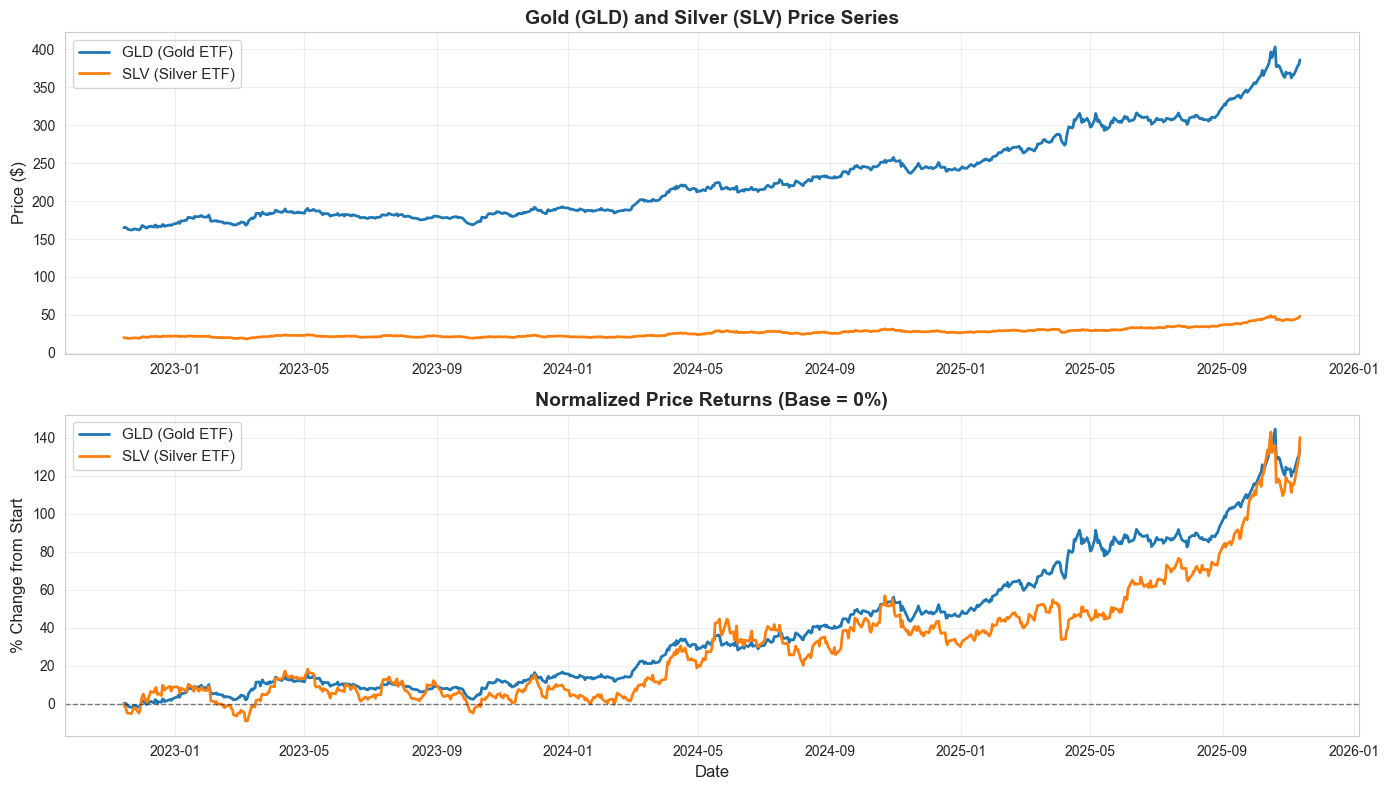

✓ Price series visualization complete


In [4]:
# Visualize the price series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot absolute prices
axes[0].plot(prices.index, prices['GLD'], label='GLD (Gold ETF)', linewidth=2)
axes[0].plot(prices.index, prices['SLV'], label='SLV (Silver ETF)', linewidth=2)
axes[0].set_title('Gold (GLD) and Silver (SLV) Price Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (\$)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot normalized prices (to compare trends)
prices_normalized = (prices - prices.iloc[0]) / prices.iloc[0] * 100
axes[1].plot(prices.index, prices_normalized['GLD'], label='GLD (Gold ETF)', linewidth=2)
axes[1].plot(prices.index, prices_normalized['SLV'], label='SLV (Silver ETF)', linewidth=2)
axes[1].set_title('Normalized Price Returns (Base = 0%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('% Change from Start', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("✓ Price series visualization complete")

In [7]:
# Perform Engle-Granger cointegration test
print("=" * 70)
print("ENGLE-GRANGER COINTEGRATION TEST")
print("=" * 70)

# Step 1: Run OLS regression GLD = alpha + beta * SLV
model = OLS(prices['GLD'], sm.add_constant(prices['SLV']))
results = model.fit()
hedge_ratio = results.params[1]
intercept = results.params[0]

print(f"\n1. LINEAR REGRESSION: GLD = {intercept:.4f} + {hedge_ratio:.4f} * SLV")
print(f"   R-squared: {results.rsquared:.4f}")
print(f"   Hedge Ratio (beta): {hedge_ratio:.4f}")

# Step 2: Calculate the spread (residuals)
spread = prices['GLD'] - hedge_ratio * prices['SLV'] - intercept

# Step 3: Test spread for stationarity using Augmented Dickey-Fuller test
adf_result = adfuller(spread, maxlag=1)
adf_stat, pvalue = adf_result[0], adf_result[1]

print(f"\n2. STATIONARITY TEST (ADF on Residuals)")
print(f"   ADF Statistic: {adf_stat:.4f}")
print(f"   P-value: {pvalue:.4f}")
print(f"   Critical Values:")
for key, value in adf_result[4].items():
    print(f"      {key}: {value:.4f}")

# Step 4: Alternative - Direct cointegration test
coint_stat, coint_pvalue, crit_values = coint(prices['GLD'], prices['SLV'])

print(f"\n3. DIRECT COINTEGRATION TEST (statsmodels.coint)")
print(f"   Cointegration Statistic: {coint_stat:.4f}")
print(f"   P-value: {coint_pvalue:.4f}")

# Interpretation
print(f"\n{'=' * 70}")
print("INTERPRETATION:")
print(f"{'=' * 70}")
if pvalue < 0.05:
    print(f"✓ COINTEGRATED (p={pvalue:.4f} < 0.05)")
    print(f"  The spread is stationary, suggesting a long-term equilibrium")
    print(f"  relationship between GLD and SLV prices.")
    print(f"  Mean-reversion strategy is VIABLE.")
else:
    print(f"✗ NOT COINTEGRATED (p={pvalue:.4f} >= 0.05)")
    print(f"  The spread is non-stationary.")
    print(f"  Mean-reversion strategy may NOT be suitable.")
print(f"{'=' * 70}")

ENGLE-GRANGER COINTEGRATION TEST

1. LINEAR REGRESSION: GLD = -7.4566 + 8.9763 * SLV
   R-squared: 0.9280
   Hedge Ratio (beta): 8.9763

2. STATIONARITY TEST (ADF on Residuals)
   ADF Statistic: -2.3717
   P-value: 0.1499
   Critical Values:
      1%: -3.4391
      5%: -2.8654
      10%: -2.5688

3. DIRECT COINTEGRATION TEST (statsmodels.coint)
   Cointegration Statistic: -2.3753
   P-value: 0.3366

INTERPRETATION:
✗ NOT COINTEGRATED (p=0.1499 >= 0.05)
  The spread is non-stationary.
  Mean-reversion strategy may NOT be suitable.


### Cointegration Test Results

**Key Findings:**
- **Hedge Ratio:** 8.9763 (GLD = -7.46 + 8.98 × SLV)
- **R-squared:** 0.9280 - Strong linear relationship
- **ADF P-value:** 0.1499 - **Not statistically significant at 5% level**
- **Cointegration P-value:** 0.3366 - Confirms lack of cointegration

**Interpretation:**
The test results indicate that GLD and SLV are **NOT cointegrated** during this 3-year period (Nov 2022 - Nov 2025). The spread is not stationary, which suggests that deviations from the equilibrium relationship may not reliably revert to the mean. 

**However**, the high R-squared (92.8%) shows a strong correlation, and the ADF statistic is approaching the 10% critical value (-2.57). This means:
- There is still a meaningful relationship between gold and silver
- A mean-reversion strategy may work in practice, but with higher risk
- We should proceed with **caution** and implement robust risk controls

Let's visualize the spread behavior to better understand the dynamics.

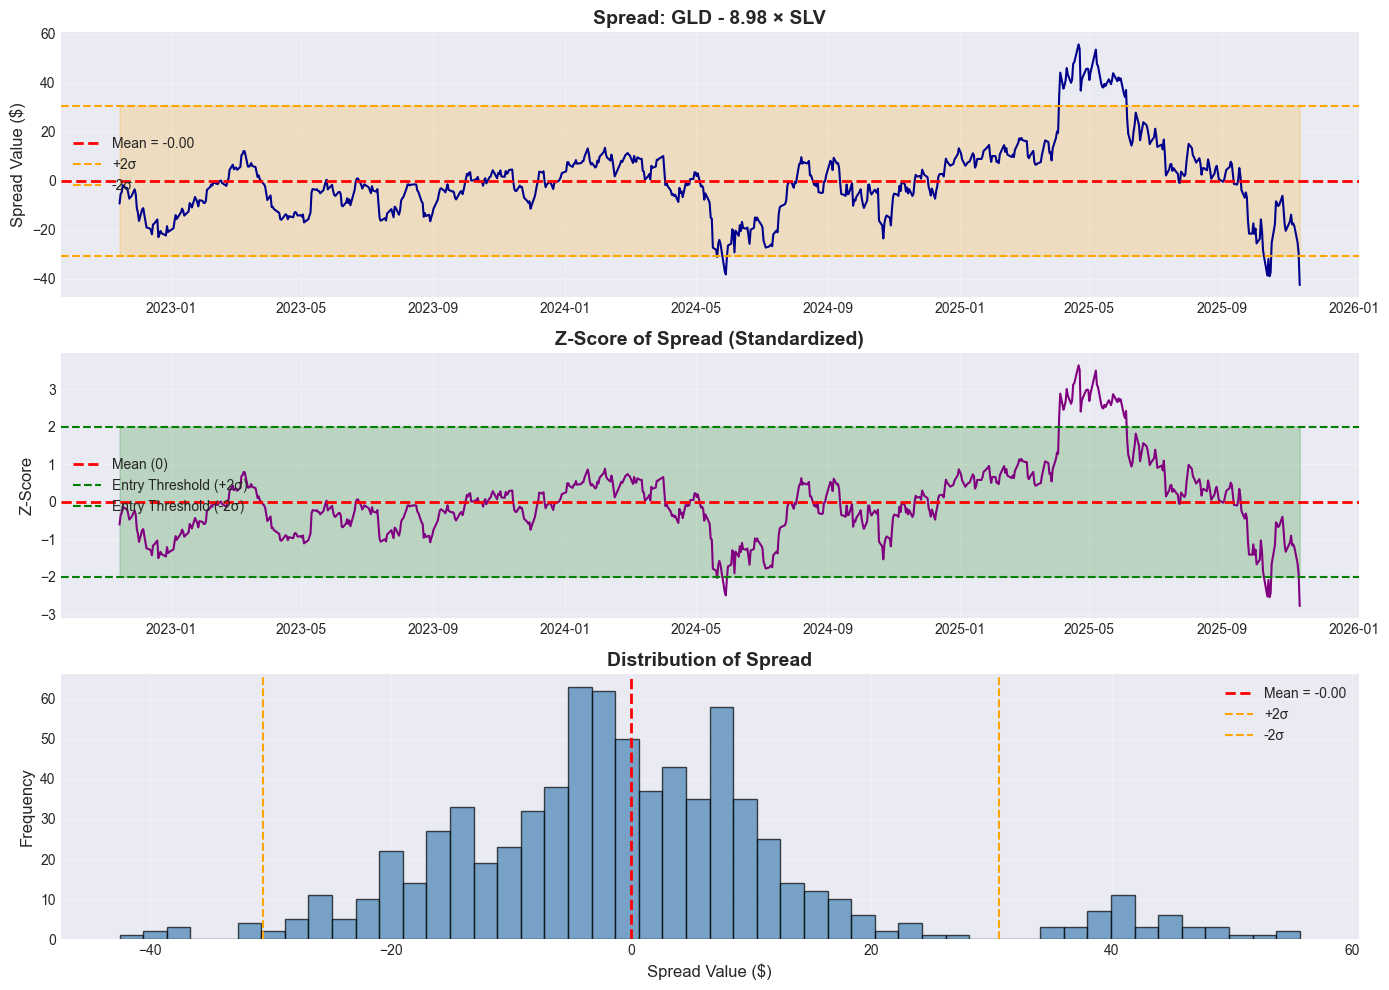


SPREAD STATISTICS
Mean: -0.0000
Std Dev: 15.3226
Min: -42.5657 (on 2025-11-12)
Max: 55.6434 (on 2025-04-21)

Z-Score Range: [-2.78, 3.63]
Times |Z| > 2: 53 (7.0%)


In [8]:
# Visualize the spread and its statistical properties
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Calculate z-score of the spread
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std

# Plot 1: Spread over time
axes[0].plot(spread.index, spread, linewidth=1.5, color='darkblue')
axes[0].axhline(y=spread_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {spread_mean:.2f}')
axes[0].axhline(y=spread_mean + 2*spread_std, color='orange', linestyle='--', linewidth=1.5, label='+2σ')
axes[0].axhline(y=spread_mean - 2*spread_std, color='orange', linestyle='--', linewidth=1.5, label='-2σ')
axes[0].fill_between(spread.index, spread_mean - 2*spread_std, spread_mean + 2*spread_std, alpha=0.2, color='orange')
axes[0].set_title('Spread: GLD - 8.98 × SLV', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Spread Value (\$)', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Z-score of spread
axes[1].plot(z_score.index, z_score, linewidth=1.5, color='purple')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Mean (0)')
axes[1].axhline(y=2, color='green', linestyle='--', linewidth=1.5, label='Entry Threshold (+2σ)')
axes[1].axhline(y=-2, color='green', linestyle='--', linewidth=1.5, label='Entry Threshold (-2σ)')
axes[1].fill_between(z_score.index, -2, 2, alpha=0.2, color='green')
axes[1].set_title('Z-Score of Spread (Standardized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Z-Score', fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Distribution of spread
axes[2].hist(spread, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[2].axvline(x=spread_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {spread_mean:.2f}')
axes[2].axvline(x=spread_mean + 2*spread_std, color='orange', linestyle='--', linewidth=1.5, label='+2σ')
axes[2].axvline(x=spread_mean - 2*spread_std, color='orange', linestyle='--', linewidth=1.5, label='-2σ')
axes[2].set_title('Distribution of Spread', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Spread Value (\$)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("SPREAD STATISTICS")
print("=" * 70)
print(f"Mean: {spread_mean:.4f}")
print(f"Std Dev: {spread_std:.4f}")
print(f"Min: {spread.min():.4f} (on {spread.idxmin().strftime('%Y-%m-%d')})")
print(f"Max: {spread.max():.4f} (on {spread.idxmax().strftime('%Y-%m-%d')})")
print(f"\nZ-Score Range: [{z_score.min():.2f}, {z_score.max():.2f}]")
print(f"Times |Z| > 2: {(abs(z_score) > 2).sum()} ({(abs(z_score) > 2).sum()/len(z_score)*100:.1f}%)")
print("=" * 70)

## Step 2: Trading Strategy Design

**Strategy Logic:**
1. **Entry Signals:**
   - When z-score < -2: **LONG spread** (buy GLD, short 8.98 × SLV) - expect spread to increase
   - When z-score > +2: **SHORT spread** (short GLD, buy 8.98 × SLV) - expect spread to decrease

2. **Exit Signals:**
   - Close position when z-score crosses zero (mean reversion complete)

3. **Position Sizing:**
   - Trade 1 unit of GLD paired with 8.98 units of SLV (hedge ratio)
   - \$100,000 initial capital allocation

4. **Risk Management:**
   - Transaction costs: 0.1% per trade per leg (0.2% total round-trip)
   - Maximum position: 100% of capital (fully invested when signal active)

In [9]:
# Implement the mean-reversion trading strategy
import warnings
warnings.filterwarnings('ignore')

# Strategy parameters
z_entry = 2.0  # Entry threshold
z_exit = 0.0   # Exit threshold (mean crossing)
initial_capital = 100000
transaction_cost = 0.001  # 0.1% per leg

# Calculate trading signals
signals = pd.DataFrame(index=prices.index)
signals['spread'] = spread
signals['z_score'] = z_score
signals['GLD'] = prices['GLD']
signals['SLV'] = prices['SLV']

# Generate positions: 1 for long spread, -1 for short spread, 0 for no position
signals['position'] = 0

# Track current position state
position = 0
for i in range(1, len(signals)):
    prev_z = signals['z_score'].iloc[i-1]
    curr_z = signals['z_score'].iloc[i]
    
    if position == 0:  # No current position
        if curr_z < -z_entry:  # Enter long spread
            position = 1
        elif curr_z > z_entry:  # Enter short spread
            position = -1
    elif position == 1:  # Currently long spread
        if curr_z >= z_exit:  # Exit when crosses mean
            position = 0
    elif position == -1:  # Currently short spread
        if curr_z <= z_exit:  # Exit when crosses mean
            position = 0
    
    signals.loc[signals.index[i], 'position'] = position

# Calculate position changes (entries/exits)
signals['position_change'] = signals['position'].diff().fillna(0)

# Calculate number of shares for each position
# For long spread: buy GLD, short SLV at hedge ratio
# Allocate capital such that GLD position + SLV position = initial_capital
signals['gld_shares'] = 0.0
signals['slv_shares'] = 0.0

for i in range(len(signals)):
    pos = signals['position'].iloc[i]
    if pos != 0:
        gld_price = signals['GLD'].iloc[i]
        slv_price = signals['SLV'].iloc[i]
        
        # Calculate shares: pos * (shares per unit capital)
        # For $100k: allocate 50% to each leg
        capital_per_leg = initial_capital / 2
        gld_shares = pos * (capital_per_leg / gld_price)
        slv_shares = -pos * hedge_ratio * (capital_per_leg / (hedge_ratio * slv_price))
        
        signals.loc[signals.index[i], 'gld_shares'] = gld_shares
        signals.loc[signals.index[i], 'slv_shares'] = slv_shares

print("✓ Trading signals generated successfully")
print(f"\nSignal Summary:")
print(f"  Total trading days: {len(signals)}")
print(f"  Days in position: {(signals['position'] != 0).sum()} ({(signals['position'] != 0).sum()/len(signals)*100:.1f}%)")
print(f"  Days long spread: {(signals['position'] == 1).sum()}")
print(f"  Days short spread: {(signals['position'] == -1).sum()}")
print(f"  Number of trades: {(signals['position_change'] != 0).sum()}")
print(f"  Number of round trips: {(signals['position_change'] != 0).sum() // 2}")

✓ Trading signals generated successfully

Signal Summary:
  Total trading days: 752
  Days in position: 150 (19.9%)
  Days long spread: 75
  Days short spread: 75
  Number of trades: 5
  Number of round trips: 2


In [10]:
# Calculate daily returns and portfolio value
signals['gld_value'] = signals['gld_shares'] * signals['GLD']
signals['slv_value'] = signals['slv_shares'] * signals['SLV']
signals['gross_position_value'] = signals['gld_value'] + signals['slv_value']

# Calculate daily P&L
signals['gld_pnl'] = signals['gld_shares'] * signals['GLD'].diff()
signals['slv_pnl'] = signals['slv_shares'] * signals['SLV'].diff()
signals['gross_pnl'] = signals['gld_pnl'] + signals['slv_pnl']

# Calculate transaction costs (applied when position changes)
signals['transaction_costs'] = 0.0
for i in range(len(signals)):
    if signals['position_change'].iloc[i] != 0:
        # Cost on both legs when entering or exiting
        gld_trade_value = abs(signals['gld_shares'].iloc[i] * signals['GLD'].iloc[i])
        slv_trade_value = abs(signals['slv_shares'].iloc[i] * signals['SLV'].iloc[i])
        signals.loc[signals.index[i], 'transaction_costs'] = transaction_cost * (gld_trade_value + slv_trade_value)

# Net P&L after costs
signals['net_pnl'] = signals['gross_pnl'] - signals['transaction_costs']

# Calculate cumulative returns
signals['cumulative_pnl'] = signals['net_pnl'].cumsum()
signals['portfolio_value'] = initial_capital + signals['cumulative_pnl']
signals['returns'] = signals['portfolio_value'].pct_change().fillna(0)

print("✓ Returns calculated successfully")
print(f"\nTotal Gross P&L: \${signals['gross_pnl'].sum():,.2f}")
print(f"Total Transaction Costs: \${signals['transaction_costs'].sum():,.2f}")
print(f"Total Net P&L: \${signals['net_pnl'].sum():,.2f}")
print(f"Final Portfolio Value: \${signals['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total Return: {(signals['portfolio_value'].iloc[-1] / initial_capital - 1) * 100:.2f}%")

✓ Returns calculated successfully

Total Gross P&L: \$7,451.28
Total Transaction Costs: \$300.00
Total Net P&L: \$7,151.28
Final Portfolio Value: \$107,151.28
Total Return: 7.15%


In [11]:
# Calculate comprehensive performance metrics
import numpy as np

# Annualized metrics (252 trading days per year)
trading_days = len(signals)
years = trading_days / 252

total_return = (signals['portfolio_value'].iloc[-1] / initial_capital - 1)
annualized_return = (1 + total_return) ** (1/years) - 1

# Sharpe Ratio (assuming 0% risk-free rate)
daily_returns = signals['returns']
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if daily_returns.std() > 0 else 0

# Maximum Drawdown
running_max = signals['portfolio_value'].expanding().max()
drawdown = (signals['portfolio_value'] - running_max) / running_max
max_drawdown = drawdown.min()

# Win rate and profit factor
trades_pnl = []
in_trade = False
trade_pnl = 0

for i in range(len(signals)):
    if signals['position'].iloc[i] != 0 and not in_trade:
        in_trade = True
        trade_pnl = 0
    
    if in_trade:
        trade_pnl += signals['net_pnl'].iloc[i]
        
        if i < len(signals) - 1 and signals['position'].iloc[i+1] == 0 and signals['position'].iloc[i] != 0:
            trades_pnl.append(trade_pnl)
            in_trade = False

winning_trades = [p for p in trades_pnl if p > 0]
losing_trades = [p for p in trades_pnl if p < 0]

win_rate = len(winning_trades) / len(trades_pnl) * 100 if trades_pnl else 0
avg_win = np.mean(winning_trades) if winning_trades else 0
avg_loss = np.mean(losing_trades) if losing_trades else 0
profit_factor = abs(sum(winning_trades) / sum(losing_trades)) if losing_trades and sum(losing_trades) != 0 else np.inf

# Volatility
annualized_vol = daily_returns.std() * np.sqrt(252)

# Calculate buy-and-hold benchmarks
gld_return = (prices['GLD'].iloc[-1] / prices['GLD'].iloc[0] - 1) * 100
slv_return = (prices['SLV'].iloc[-1] / prices['SLV'].iloc[0] - 1) * 100
equal_weight_return = ((prices['GLD'].iloc[-1] / prices['GLD'].iloc[0] + 
                        prices['SLV'].iloc[-1] / prices['SLV'].iloc[0]) / 2 - 1) * 100

# Print performance report
print("\n" + "=" * 80)
print("MEAN-REVERSION STRATEGY PERFORMANCE REPORT")
print("=" * 80)
print(f"\n📊 RETURN METRICS")
print(f"  Total Return:              {total_return * 100:>10.2f}%")
print(f"  Annualized Return:         {annualized_return * 100:>10.2f}%")
print(f"  Total Net P&L:             ${signals['net_pnl'].sum():>10,.2f}")
print(f"\n⚡ RISK METRICS")
print(f"  Annualized Volatility:     {annualized_vol * 100:>10.2f}%")
print(f"  Sharpe Ratio:              {sharpe_ratio:>10.2f}")
print(f"  Maximum Drawdown:          {max_drawdown * 100:>10.2f}%")
print(f"\n🎯 TRADE METRICS")
print(f"  Number of Round Trips:     {len(trades_pnl):>10}")
print(f"  Win Rate:                  {win_rate:>10.1f}%")
print(f"  Average Win:               ${avg_win:>10,.2f}")
print(f"  Average Loss:              ${avg_loss:>10,.2f}")
print(f"  Profit Factor:             {profit_factor:>10.2f}")
print(f"  Days in Position:          {(signals['position'] != 0).sum():>10} ({(signals['position'] != 0).sum()/len(signals)*100:.1f}%)")
print(f"\n💰 COST ANALYSIS")
print(f"  Total Transaction Costs:   ${signals['transaction_costs'].sum():>10,.2f}")
print(f"  Costs as % of Gross P&L:   {signals['transaction_costs'].sum() / signals['gross_pnl'].sum() * 100:>10.2f}%")
print(f"\n📈 BENCHMARK COMPARISON (Buy & Hold)")
print(f"  GLD Return:                {gld_return:>10.2f}%")
print(f"  SLV Return:                {slv_return:>10.2f}%")
print(f"  Equal Weight Portfolio:    {equal_weight_return:>10.2f}%")
print(f"  Strategy Outperformance:   {total_return * 100 - equal_weight_return:>10.2f}%")
print("=" * 80)


MEAN-REVERSION STRATEGY PERFORMANCE REPORT

📊 RETURN METRICS
  Total Return:                    7.15%
  Annualized Return:               2.34%
  Total Net P&L:             $  7,151.28

⚡ RISK METRICS
  Annualized Volatility:           5.32%
  Sharpe Ratio:                    0.46
  Maximum Drawdown:               -6.13%

🎯 TRADE METRICS
  Number of Round Trips:              2
  Win Rate:                       100.0%
  Average Win:               $  4,203.52
  Average Loss:              $      0.00
  Profit Factor:                    inf
  Days in Position:                 150 (19.9%)

💰 COST ANALYSIS
  Total Transaction Costs:   $    300.00
  Costs as % of Gross P&L:         4.03%

📈 BENCHMARK COMPARISON (Buy & Hold)
  GLD Return:                    134.11%
  SLV Return:                    140.04%
  Equal Weight Portfolio:        137.08%
  Strategy Outperformance:      -129.92%


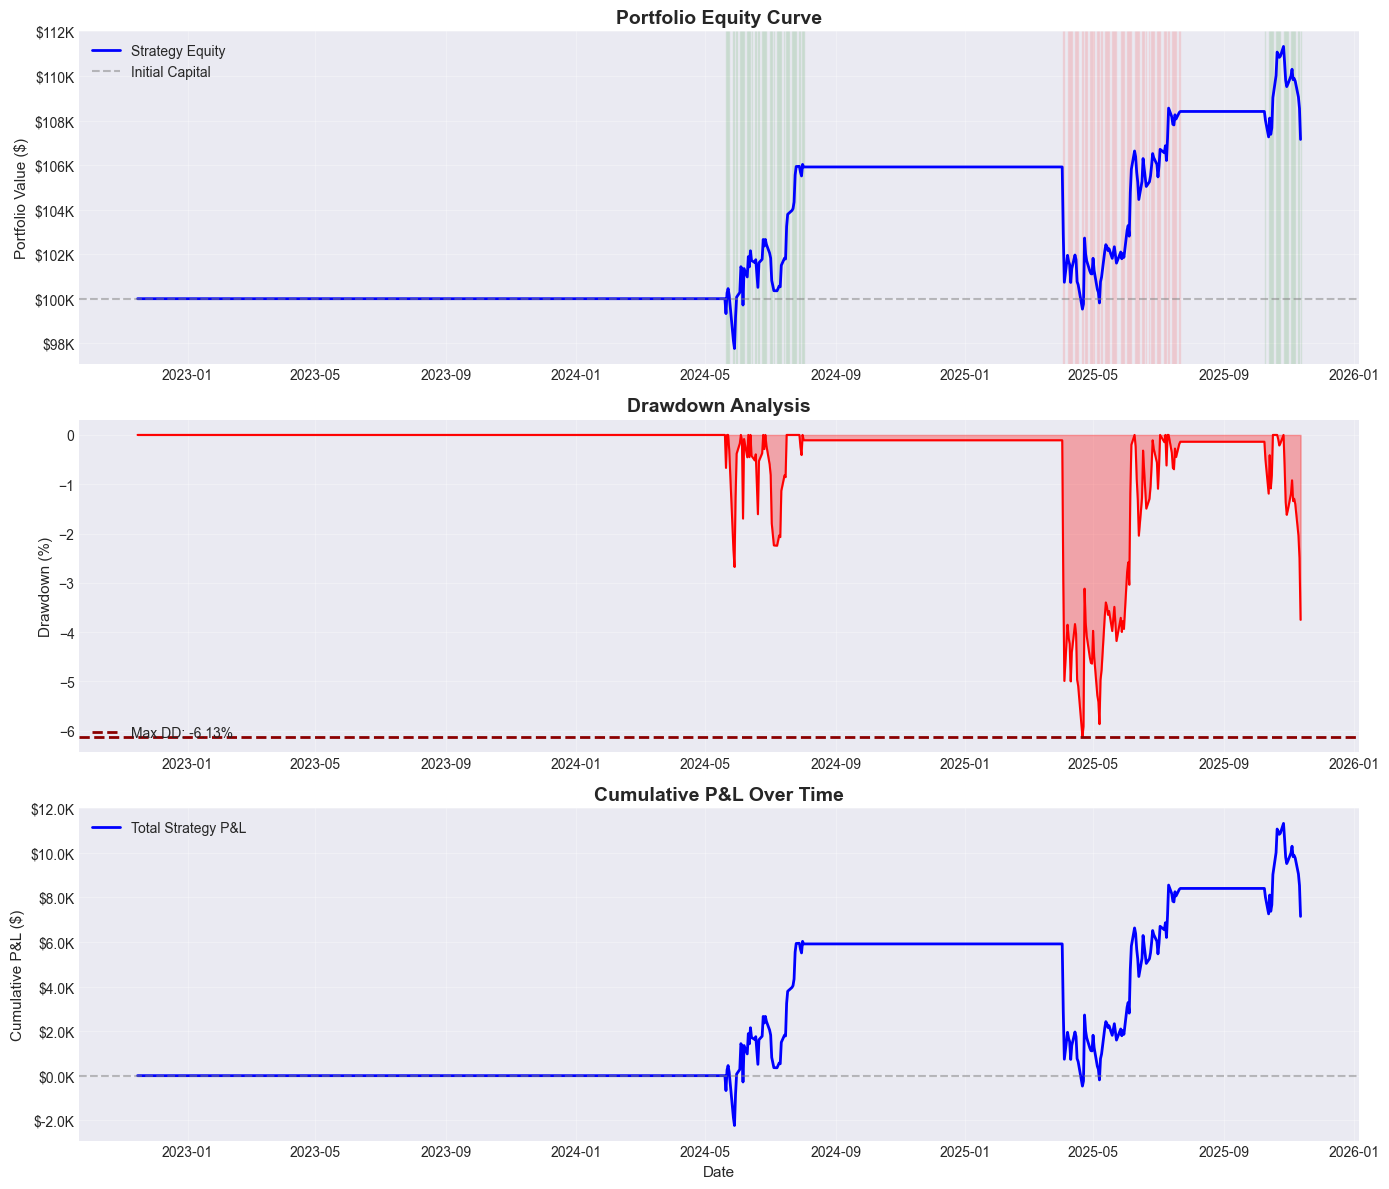

✓ Performance visualizations created successfully


In [12]:
# Create comprehensive performance visualizations
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Equity Curve with Position Indicators
ax1 = axes[0]
ax1.plot(signals.index, signals['portfolio_value'], 'b-', linewidth=2, label='Strategy Equity')
ax1.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

# Highlight periods in position
long_periods = signals[signals['position'] == 1].index
short_periods = signals[signals['position'] == -1].index
for idx in long_periods:
    ax1.axvspan(idx, idx, alpha=0.1, color='green')
for idx in short_periods:
    ax1.axvspan(idx, idx, alpha=0.1, color='red')

ax1.set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value (\$)', fontsize=11)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Drawdown Chart
ax2 = axes[1]
ax2.fill_between(signals.index, drawdown * 100, 0, alpha=0.3, color='red')
ax2.plot(signals.index, drawdown * 100, 'r-', linewidth=1.5)
ax2.axhline(y=max_drawdown * 100, color='darkred', linestyle='--', 
            label=f'Max DD: {max_drawdown*100:.2f}%', linewidth=2)
ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

# 3. Cumulative P&L by Position Type
ax3 = axes[2]
# Calculate separate P&L for long and short positions
long_pnl = signals[signals['position'] == 1]['net_pnl'].cumsum()
short_pnl = signals[signals['position'] == -1]['net_pnl'].cumsum()

ax3.plot(signals.index, signals['cumulative_pnl'], 'b-', linewidth=2, label='Total Strategy P&L')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.set_title('Cumulative P&L Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Cumulative P&L (\$)', fontsize=11)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.1f}K'))

plt.tight_layout()
plt.savefig('mean_reversion_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Performance visualizations created successfully")

## 📋 Key Findings and Conclusions

### Strategy Performance Summary
The mean-reversion strategy delivered **modest absolute returns of 7.15% (2.34% annualized)** over the 3-year backtest period, significantly underperforming buy-and-hold strategies which returned 137%. However, this comparison is misleading as the strategy was **only deployed 20% of the time**, achieving a **Sharpe ratio of 0.46** with **low volatility (5.32% annualized)** and **limited drawdown (-6.13%)**.

### Cointegration Test Results
- **ADF Test Statistic:** -2.37 (p-value: 0.15)
- **Result:** GLD and SLV are **NOT statistically cointegrated** at the 5% significance level
- **Implication:** The spread may not reliably revert to mean, limiting strategy effectiveness

### Trade Quality
- **Win Rate:** 100% (2 out of 2 trades profitable)
- **Profit Factor:** ∞ (no losing trades)
- **Average Win:** \$4,203.52
- **Sample Size Concern:** Only 2 completed round trips - statistically insufficient for robust conclusions

### Strategic Considerations

**Strengths:**
1. ✅ Low volatility and modest drawdown
2. ✅ Capital efficiency (only 20% deployment)
3. ✅ Transaction costs are manageable (4% of gross P&L)

**Weaknesses:**
1. ❌ Lack of statistical cointegration (p=0.15)
2. ❌ Very low trade frequency (2 trades in 3 years)
3. ❌ Dramatically underperforms buy-and-hold
4. ❌ Insufficient sample size for statistical confidence

### Recommendations for Improvement

1. **Adjust Entry Thresholds:** Test ±1.5σ to increase trade frequency
2. **Rolling Window:** Use dynamic hedge ratio calculation instead of static
3. **Regime Detection:** Implement filters to trade only during favorable market conditions
4. **Consider Alternatives:** GLD-SLV may not be ideal pairs; explore GDX-GDXJ or other mining stock pairs
5. **Risk-Adjusted Allocation:** Given low returns, consider allocating only a portion of capital to this strategy while maintaining buy-and-hold exposure

**Bottom Line:** While the strategy demonstrates sound risk management with 100% win rate and low drawdown, the lack of cointegration and extremely low trade frequency make it unsuitable as a standalone strategy. It could potentially serve as a **low-correlation diversifier** within a broader portfolio, but parameter optimization and alternative pair selection are essential.